In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.spines as spines
import seaborn as sns
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks

In [2]:
from google.colab import files 

In [3]:
uploaded=files.upload()

Saving kaggle_bee_vs_wasp.zip to kaggle_bee_vs_wasp.zip


In [5]:
import zipfile

local_zip = '/content/kaggle_bee_vs_wasp.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()




In [6]:
DATASET_PATH = '/content/kaggle_bee_vs_wasp'

label_csv = os.path.join(DATASET_PATH, 'labels.csv')

### Data Exploration

In [7]:
label_df = pd.read_csv(label_csv)
label_df.head(15)

id                               path  ...  is_final_validation  label
0    1  bee1\10007154554_026417cfd0_n.jpg  ...                    0    bee
1    2  bee1\10024864894_6dc54d4b34_n.jpg  ...                    1    bee
2    3  bee1\10092043833_7306dfd1f0_n.jpg  ...                    0    bee
3    4   bee1\1011948979_fc3637e779_w.jpg  ...                    1    bee
4    5  bee1\10128235063_dca17db76c_n.jpg  ...                    0    bee
5    6  bee1\10130729734_f68738333e_w.jpg  ...                    0    bee
6    7  bee1\10166485783_9cd6706c72_n.jpg  ...                    0    bee
7    8     bee1\10179824_84803290ac_m.jpg  ...                    0    bee
8    9  bee1\10197482094_0176d1bacb_n.jpg  ...                    0    bee
9   10  bee1\10242298546_aac12f5223_n.jpg  ...                    0    bee
10  11  bee1\10290912366_20f0dbdb0e_m.jpg  ...                    0    bee
11  12  bee1\10290912366_20f0dbdb0e_n.jpg  ...                    0    bee
12  13  bee1\10319307805_02d44f6555_m.jpg  ...                    0    bee
13  14  bee1\10319312035_07f21405de_n.jpg  ...                    0    bee
14  15  bee1\10330536605_77cd1d5e37_n.jpg  ...                    0    bee

[15 rows x 10 columns]

labels.csv columns description :

id - ordinal - unique index

*   path - string - relative path to the photo, including extensiom
*   is_bee - nominal - 1 if there is a bee in the photo
*   is_wasp - nominal - 1 if there is a wasp in the photo
*   is_otherinsect - nominal - 1 if there is other insect prominently in the centre of the photo, but it is not a wasp and not a bee. It might be a fly, but there are other things there too, like beetles
*   is_other - random photos not containing any insects
*   photo_quality - 1 for photos where I have very high confidence that it is bee, wasp, or other. 0 for photos of generally low quality or where I am not very confident that it is - what it says it is. You can use this to initially reduce the size of the training set
*   is_validation - you can use this for your training validation, or you can combine these with the training data and split your training/validation differently
*   is_final_validation - do NOT use these photos for training - use them to compute your final score. This will enable comparing results by different kagglers. Optionally, if you want to deploy an app to actually serve the model, you can then use these for final training too.





Searching for missing values

In [8]:
print('Number of null values ')
label_df.isnull().sum()

Number of null values 


id                     0
path                   0
is_bee                 0
is_wasp                0
is_otherinsect         0
is_other               0
photo_quality          0
is_validation          0
is_final_validation    0
label                  0
dtype: int64

Generate a new column to identify if its train, test or validation image. 
For the Kaggles description of the dataset we know that if column is_validation equal to 1, the image belongs to the validation set, and if in is_final_validation equals to one, belongs to test set.

In [9]:
def set_train_type(row):
  if row['is_validation'] == 0 and row['is_final_validation'] == 0:
    return 'train'
  if row['is_validation'] == 1 :
    return 'validation'
  return 'test'

label_df['type'] = label_df.apply(set_train_type, axis = 1)
print('Number of values for each type')
label_df['type'].value_counts()

Number of values for each type


train         7939
test          1763
validation    1719
Name: type, dtype: int64

### Visualizing the data

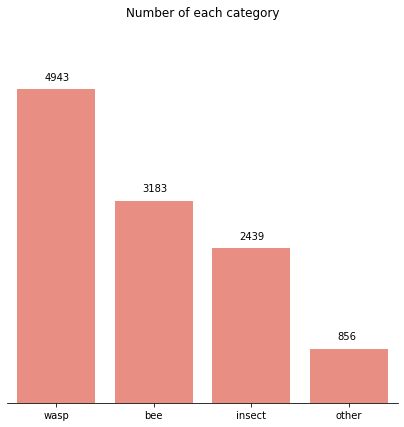

In [10]:
insect_cat_counts = label_df["label"].value_counts()

plt.figure(figsize=(7,7))
g = sns.barplot(x=insect_cat_counts.index, y =insect_cat_counts, color='salmon')
g.set(title='Number of each category', ylim=[0,6000], yticks=[], ylabel='')
sns.despine(top=True, right=True, left=True, bottom=False)

for i in range(4):
    plt.text(x=i-0.12, y=insect_cat_counts[i] + 150, s=insect_cat_counts[i])
plt.show()

wasp is the category with most number of images, followed by, bee, insect and other insect. This numbers includes test, validation and training sets.

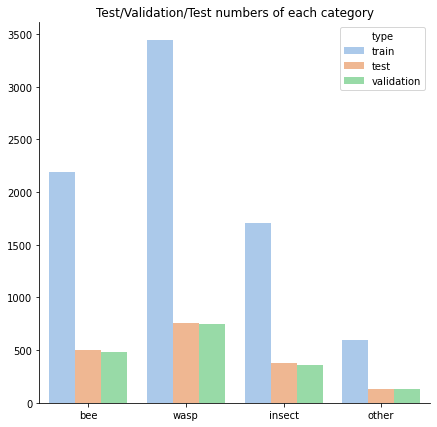

In [11]:
plt.figure(figsize=(7,7))
g = sns.countplot(x='label', hue='type', data=label_df, palette="pastel")
g.set(xlabel='', ylabel='', title="Test/Validation/Test numbers of each category")
sns.despine()
plt.show()

As showed in the graph, all the categories are well distributed, separated byt the same portion

Function for ploting images

In [12]:
def display_img(row, pos):
    #Because path use back slash which is 
    #not compatible for both windows nor linux environment
    #we will first replace back slash with forward slash
    fn = row['path'].replace('\\', os.sep)
    fn = os.path.join(DATASET_PATH, fn)
    #Read image from path
    img = cv2.imread(fn)
    #Resize all images with the same size
    img = cv2.resize(img, (128, 128))
    #Set RGB color for image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Display image, and set title
    plt.subplot(4, 5, pos)
    plt.imshow(img)
    plt.title(row['label'])
    #Remove ticks
    plt.xticks([])
    plt.yticks([])

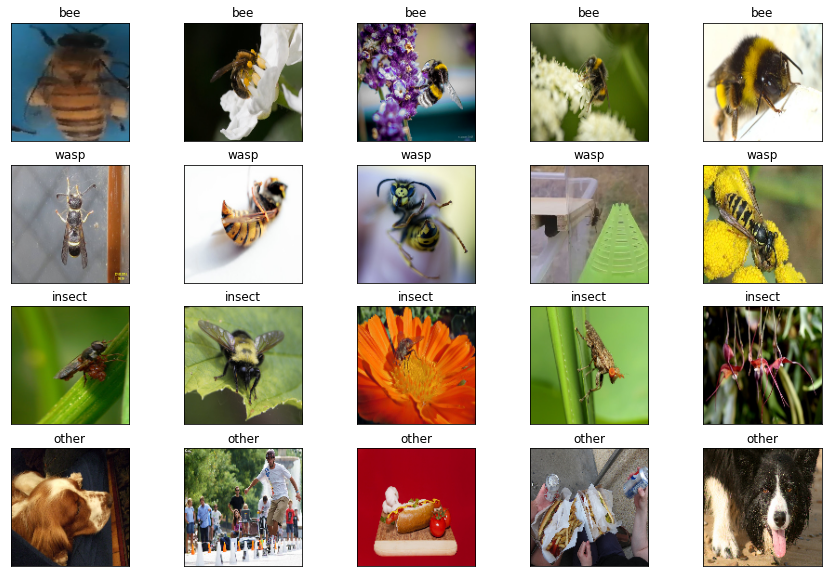

In [13]:
bee = label_df[label_df["label"] == 'bee'].sample(5, random_state=42)
wasp = label_df[label_df["label"] == 'wasp'].sample(5, random_state=42)
insect = label_df[label_df["label"] == 'insect'].sample(5, random_state=42)
other = label_df[label_df["label"] == 'other'].sample(5, random_state=42)

plt.figure(figsize=(15,10))
pos = 1
# Display bee
for idx, row in bee.iterrows():
    display_img(row, pos)
    pos += 1
# Display wasp    
for idx, row in wasp.iterrows():
    display_img(row, pos)
    pos += 1
# Display other insects
for idx, row in insect.iterrows():
    display_img(row, pos)
    pos += 1
# Display others
for idx, row in other.iterrows():
    display_img(row, pos)
    pos += 1
    
plt.show()

### Data Preparation

Divide the different datasets

In [14]:
label_df['path'] = label_df['path'].str.replace('\\', os.sep)
label_df['path'].head()

0    bee1/10007154554_026417cfd0_n.jpg
1    bee1/10024864894_6dc54d4b34_n.jpg
2    bee1/10092043833_7306dfd1f0_n.jpg
3     bee1/1011948979_fc3637e779_w.jpg
4    bee1/10128235063_dca17db76c_n.jpg
Name: path, dtype: object

In [15]:
train_df = label_df[label_df['type'] == 'train']
valid_df = label_df[label_df['type'] == 'validation']
test_df = label_df[label_df['type'] == 'test']

Creata a datagen, reescaling al the images to the desired size, and also setting up for a future data augmentation if necessary

In [16]:
TARGET_SIZE = (256, 256)

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_datagen = datagen.flow_from_dataframe(train_df, 
                                            directory=DATASET_PATH, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

valid_datagen = datagen.flow_from_dataframe(valid_df,
                                            directory=DATASET_PATH, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

test_datagen = datagen.flow_from_dataframe(test_df, 
                                           directory=DATASET_PATH, 
                                           x_col='path', 
                                           y_col='label',
                                           target_size=TARGET_SIZE,
                                           seed=42
                                           ) 

Found 7939 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.


In [17]:
n_class = len(label_df['label'].unique())


### Train, and evaluate 

In [18]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    # Block 1
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001), input_shape=(256,256,3)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ),    
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 2
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ),
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 3
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ), 
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 4
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ), 
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),

    # Block 5
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Dense(n_class, activation='softmax')
])

In [19]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [20]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [23]:
history = model.fit(train_datagen, 
          validation_data=valid_datagen, 
          callbacks=[early_stopping],
          batch_size=32,
          epochs=5,
         )

Epoch 1/5
249/249 [==============================] - 164s 658ms/step - loss: 0.1849 - accuracy: 0.9455 - val_loss: 0.2612 - val_accuracy: 0.8877
Epoch 2/5
249/249 [==============================] - 167s 671ms/step - loss: 0.1826 - accuracy: 0.9423 - val_loss: 0.2586 - val_accuracy: 0.8866
Epoch 3/5
249/249 [==============================] - 167s 671ms/step - loss: 0.1870 - accuracy: 0.9382 - val_loss: 0.2580 - val_accuracy: 0.8866
Epoch 4/5
249/249 [==============================] - 167s 670ms/step - loss: 0.1810 - accuracy: 0.9405 - val_loss: 0.2703 - val_accuracy: 0.8726
Epoch 5/5
249/249 [==============================] - 167s 670ms/step - loss: 0.1796 - accuracy: 0.9429 - val_loss: 0.2516 - val_accuracy: 0.8947


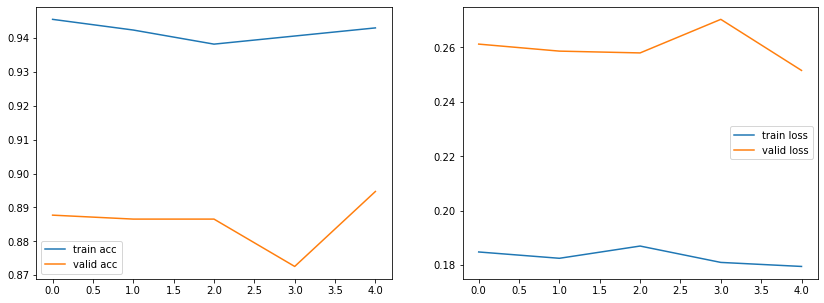

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()

In [25]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)

56/56 - 10s - loss: 0.2607 - accuracy: 0.8911
Test accuracy: 0.8910947442054749


### Transfer LEarning

In [26]:
resnet50 = keras.applications.ResNet50(include_top=False, input_shape=(256, 256, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [27]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    resnet50,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(n_class, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_datagen, 
          validation_data=valid_datagen, 
          callbacks=[early_stopping],
          batch_size=32,
          epochs=50,
         )

Epoch 1/50
249/249 [==============================] - 115s 463ms/step - loss: 0.1296 - accuracy: 0.8983 - val_loss: 0.5508 - val_accuracy: 0.4328
Epoch 2/50
249/249 [==============================] - 114s 456ms/step - loss: 0.0466 - accuracy: 0.9659 - val_loss: 0.7046 - val_accuracy: 0.5154
Epoch 3/50
249/249 [==============================] - 113s 455ms/step - loss: 0.0251 - accuracy: 0.9824 - val_loss: 0.4192 - val_accuracy: 0.7440
Epoch 4/50
249/249 [==============================] - 114s 458ms/step - loss: 0.0117 - accuracy: 0.9931 - val_loss: 0.2097 - val_accuracy: 0.8802
Epoch 5/50
249/249 [==============================] - 114s 457ms/step - loss: 0.0353 - accuracy: 0.9780 - val_loss: 0.1358 - val_accuracy: 0.9261
Epoch 6/50
249/249 [==============================] - 113s 456ms/step - loss: 0.0190 - accuracy: 0.9887 - val_loss: 0.1683 - val_accuracy: 0.9174
Epoch 7/50
249/249 [==============================] - 113s 455ms/step - loss: 0.0125 - accuracy: 0.9924 - val_loss: 0.1295 -

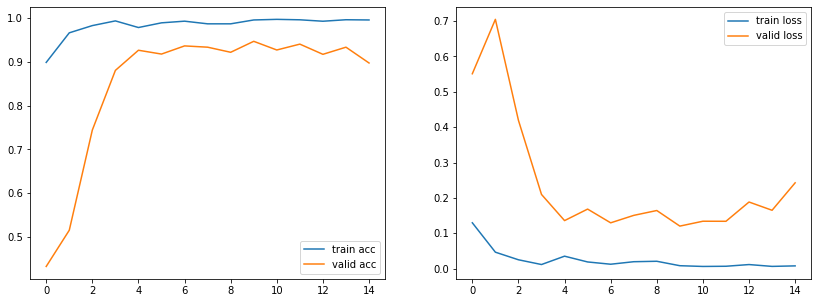

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()

In [29]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)

56/56 - 8s - loss: 0.1230 - accuracy: 0.9455
Test accuracy: 0.945547342300415
